['rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR', 'w', 'KQkq', '-', '0', '1']


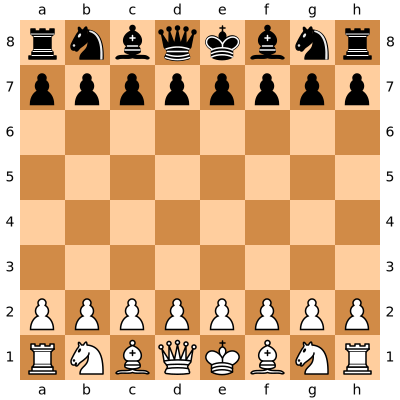

In [0]:
import chess
board = chess.Board()
fen_data = board.fen().split(" ")
print(fen_data)
board

In [0]:
## all the possibilities
one_hot_dictionary = {}
pieces = ['r', "n", "b", "q", 'k', "p"]
possibilities = pieces + [piece.upper() for piece in pieces]
print(len(possibilities))

one_hot_dictionary = {}
one_hot_dictionary["1"] = [0 for _ in range(13)]
for i, possibility in enumerate(possibilities):
    one_hot_dictionary[possibility] = [0 for _ in range(13)]
    one_hot_dictionary[possibility][i] = 1
one_hot_dictionary

12


{'1': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'r': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'n': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'b': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'q': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'k': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'p': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'R': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'N': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'B': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'Q': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'K': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'P': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]}

In [0]:
import numpy as np

def get_numpy_board(board):
    def transform_line(line):
        result = ""
        for character in line:
            if character.isdigit():
                for i in range(int(character)):
                    result += "1"
            else:
                result += character
        return result
    
    def compute_en_passant(ep_square):
        def alg_to_coord(alg):
            rank = 8 - int(alg[1])        # 0-7
            file = ord(alg[0]) - ord('a') # 0-7 #WTF ord("a")??
            return rank, file
        # renvoie une matrice de la taille dun jeu d'echec, contenant True si la case possede un 
        #pion que l'on peut manger en passant
        en_passant = np.zeros((8, 8, 1), dtype=np.bool)
        if ep_square != '-':
            eps = alg_to_coord(ep_square)
            en_passant[eps[0]][eps[1]] = True
        return en_passant

    fen_data = board.fen().split(" ")
    fen, turn, castling, ep_square, half_move_clock, fullmove_number = fen_data
    en_passant = compute_en_passant(ep_square)
    auxiliary_planes = [np.full((8, 8, 1), ('K' in castling), dtype=np.bool),
                        np.full((8, 8, 1), ('Q' in castling), dtype=np.bool),
                        np.full((8, 8, 1), ('k' in castling), dtype=np.bool),
                        np.full((8, 8, 1), ('q' in castling), dtype=np.bool),
                        en_passant]
    
    piece_information_plane = np.zeros((8,8, len(one_hot_dictionary)))
    for i, line in enumerate(fen.split("/")):
        for j, case in enumerate(transform_line(line)):
            piece_information_plane[i][j] = one_hot_dictionary[case]    
    all_planes = auxiliary_planes + [piece_information_plane]
    all_planes_numpy = np.concatenate(all_planes, axis=-1).astype(np.float32)
    return all_planes_numpy


In [0]:
def create_uci_labels():
    """
    Creates the labels for the universal chess interface into an array and returns them
    :return:
    """
    labels_array = []
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #indice colonnes echiquier
    numbers = ['1', '2', '3', '4', '5', '6', '7', '8'] #indice lignes echiquier
    promoted_to = ['q', 'r', 'b', 'n'] #list of the available promotion for the pawn

    for l1 in range(8):
        for n1 in range(8):
            destinations = [(t, n1) for t in range(8)] + \
                           [(l1, t) for t in range(8)] + \
                           [(l1 + t, n1 + t) for t in range(-7, 8)] + \
                           [(l1 + t, n1 - t) for t in range(-7, 8)] + \
                           [(l1 + a, n1 + b) for (a, b) in
                            [(-2, -1), (-1, -2), (-2, 1), (1, -2), (2, -1), (-1, 2), (2, 1), (1, 2)]]
            for (l2, n2) in destinations:
                if (l1, n1) != (l2, n2) and l2 in range(8) and n2 in range(8):
                    move = letters[l1] + numbers[n1] + letters[l2] + numbers[n2]
                    labels_array.append(move)
    for l1 in range(8):
        l = letters[l1]
        for p in promoted_to:
            labels_array.append(l + '2' + l + '1' + p)
            labels_array.append(l + '7' + l + '8' + p)
            if l1 > 0:
                l_l = letters[l1 - 1]
                labels_array.append(l + '2' + l_l + '1' + p)
                labels_array.append(l + '7' + l_l + '8' + p)
            if l1 < 7:
                l_r = letters[l1 + 1]
                labels_array.append(l + '2' + l_r + '1' + p)
                labels_array.append(l + '7' + l_r + '8' + p)
    return labels_array
#tout les coups possibles
all_moves = create_uci_labels()
number_moves = len(all_moves)
assert number_moves == 1968
all_planes_numpy = get_numpy_board(board)
shape_board = list(all_planes_numpy.shape)
assert shape_board == [8,8,18]

In [0]:
import chess

def get_label_moves(board):
    labels = np.zeros((number_moves), dtype=np.bool)
    legal_moves = [str(x) for x in list(board.legal_moves)]
    for i, move in enumerate(all_moves):
        if str(move) in legal_moves:
            labels[i] = (1)
    return labels
def get_features(board):
    return get_numpy_board(board)
# get_features(board)

def get_naive_reward(board):
    return 1
# list(get_label_moves(board))

In [0]:
%%time
board = chess.Board()

#for a given board
X = get_features(board)
y = get_label_moves(board)

CPU times: user 1.58 ms, sys: 89 µs, total: 1.67 ms
Wall time: 1.68 ms


In [0]:
print(board.fen())


rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1


In [0]:
def get_unique_identifier(board):
    return str(board.board_fen()) + str(board.turn) + str(board.castling_rights) + str(board.ep_square)

In [0]:
def get_moves_until_end(observations, board, dataset_size, max_number_moves):
    if len(observations) == dataset_size or max_number_moves==0:
        return
    
    if board.turn == chess.WHITE:
        identifier = get_unique_identifier(board)
        if identifier not in observations:
                observations[identifier] = [get_features(board), get_label_moves(board)]
                if len(observations) % int(dataset_size / 100) ==0:
                    print(f" {len(observations)} observations has been simulated")
    legal_moves = list(board.legal_moves)
    if not (legal_moves):
        return
    random_move = np.random.choice(legal_moves)
    board.push(random_move)
    get_moves_until_end(observations, board , dataset_size, max_number_moves-1)

In [0]:
def generate_dataset(max_number_moves=500, dataset_size=100000):
    observations = {}
    while len(observations) < dataset_size:
        board = chess.Board()
        get_moves_until_end(observations, board, dataset_size, max_number_moves)
    X = np.zeros((dataset_size, 8,8,18), dtype=np.float32)
    y = np.zeros((dataset_size, number_moves), dtype=np.int8)
    for i, obs in enumerate(observations):
        X[i] = observations[obs][0]
        y[i] = observations[obs][1] #un peu redondant
    return X, y

In [0]:
%%time
dataset_size=10000
X, y = generate_dataset(max_number_moves=200, dataset_size=dataset_size)

 100 observations has been simulated
 200 observations has been simulated
 300 observations has been simulated
 400 observations has been simulated
 500 observations has been simulated
 600 observations has been simulated
 700 observations has been simulated
 800 observations has been simulated
 900 observations has been simulated
 1000 observations has been simulated
 1100 observations has been simulated
 1200 observations has been simulated
 1300 observations has been simulated
 1400 observations has been simulated
 1500 observations has been simulated
 1600 observations has been simulated
 1700 observations has been simulated
 1800 observations has been simulated
 1900 observations has been simulated
 2000 observations has been simulated
 2100 observations has been simulated
 2200 observations has been simulated
 2300 observations has been simulated
 2400 observations has been simulated
 2500 observations has been simulated
 2600 observations has been simulated
 2700 observations ha

In [0]:
np.save("X.npy", X)
np.save("y.npy", y)

## Est ce que j'ai tout les elements pour entrainer mon IA?

- [x] representer la position d'une partie d'echecs sous forme de matrice numpy 
- [x] la liste de tout les coups possibles pour une partie d'echecs (case a to case b etc..)
- [x] connaitre la liste des coups valides pour une position existante (`list(board.legal_moves)`)
- [x] Definition d'un mini modele qui prevoit valeur et une probabilite pour chaque coup (je fais ca maintenant)

In [0]:
import keras
from keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense
from keras.models import Model

def naive_model_value_and_move_prediction():
    NUMBER_FILTERS = 8
    #take a numpy array representing a board as input, and who plays first, and then return
    # the value of a game, number between -1 and 1
    board = Input(shape=(shape_board))
    
    features = Conv2D(filters=NUMBER_FILTERS,kernel_size=3,activation="relu", padding="same")(board)
    features = Conv2D(filters=2, kernel_size=3,activation="relu", padding="same")(features)
    print(features.shape)
    features = Flatten()(features)
#     value_prediction = Dense(1, activation="sigmoid")(features) #TRY WITH TANGENT FOR output between -1 and 1
    policy_prediction = Dense(number_moves, activation="sigmoid")(features)

    model = Model(board, policy_prediction)
    model.compile(loss=["binary_crossentropy"], optimizer="Adam")
    model.summary()
    return model
model = naive_model_value_and_move_prediction()


(None, 8, 8, 2)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8, 8, 18)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 8)           1304      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 2)           146       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1968)              253872    
Total params: 255,322
Trainable params: 255,322
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(X, y, epochs=100) # loss: 0.0344 in ~2 epochs

In [0]:
def model_moves():
    NUMBER_FILTERS = 16
    #take a numpy array representing a board as input, and who plays first, and then return
    # the value of a game, number between -1 and 1
    board = Input(shape=(shape_board))
    
    features = Conv2D(filters=NUMBER_FILTERS,kernel_size=3,activation="relu", padding="same")(board)
    features = BatchNormalization()(features)
    features = Conv2D(filters=NUMBER_FILTERS, kernel_size=3,activation="relu", padding="same")(features)
    features = BatchNormalization()(features)
    features = Conv2D(filters=2, kernel_size=3,activation="relu", padding="same")(features)
    print(features.shape)
    features = Flatten()(features)
#     value_prediction = Dense(1, activation="sigmoid")(features) #TRY WITH TANGENT FOR output between -1 and 1
    policy_prediction = Dense(number_moves, activation="sigmoid")(features)

    model = Model(board, policy_prediction)
    model.compile(loss=["binary_crossentropy"], optimizer="Adam")
    model.summary()
    return model
model = model_moves()

(None, 8, 8, 2)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 8, 8, 18)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 16)          2608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 16)          64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 16)          2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 16)          64        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 2)           290       
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)   

In [0]:
model.fit(X, y, epochs=100) # loss: 0.0344 in ~2 epochs

ValueError: Error when checking input: expected input_5 to have shape (8, 8, 18) but got array with shape (8, 8, 36)